In [122]:
import numpy as np
import pyqsp 
from tqdm import tqdm

from maxtrix_inversion_qsvt import MatrixInversionQSVT, QuantumSolverQSVT
from helpers import *

import matplotlib.pyplot as plt

# Approximate polynomial

In [82]:
# Code taken from https://github.com/ichuang/pyqsp

pg = pyqsp.poly.PolyOneOverX()

# Underlying parameters of inverse approximation.
kappa=3
epsilon=0.01
pcoefs, scale = pg.generate(kappa=kappa, epsilon=epsilon, chebyshev_basis=True, return_scale=True)

# Generate anonymous approximation and ideal function for scaled reciprocal.
inv_fun = lambda x: np.polynomial.chebyshev.chebval(x, pcoefs)
ideal_fun = lambda x: scale*np.reciprocal(x)

poly = pyqsp.angle_sequence.Chebyshev(pcoefs) # Chebyshev decomposition of 1/x
phases = np.array(pyqsp.angle_sequence.QuantumSignalProcessingPhases(poly, signal_operator="Wx", measurement="x")) # QSP phases in the Wx convention

npts = 400
full_range = np.linspace(-1., 1., npts)
D_min = np.linspace(-1., -1/kappa/10, npts//2) 
D_plus = np.linspace(1/kappa/10, 1., npts//2)

# Compute QSP response function directly according to method and convention.
qspr = pyqsp.response.ComputeQSPResponse(full_range,
                                         phases,
                                         signal_operator="Wx",
                                         measurement="x",
                                         sym_qsp=True)

# Generate total response function.
pdat = qspr['pdat']

# Grab the Re and Im parts of QSP unitary top-left matrix element.
re_vals = np.real(pdat)
im_vals = np.imag(pdat)

b=51, j0=22
[PolyOneOverX] minimum [-4.58579384] is at [-0.15726745]: normalizing


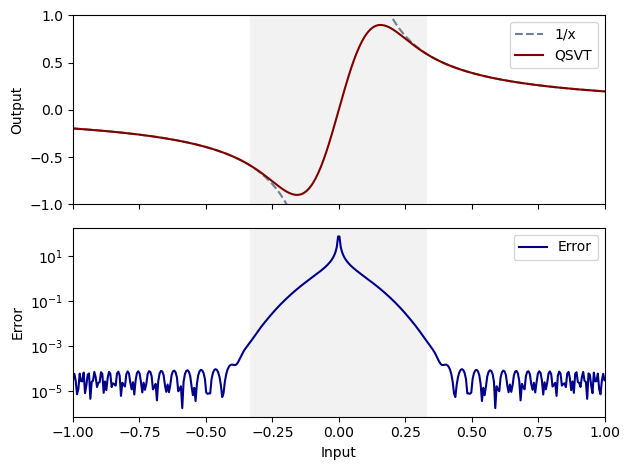

In [93]:
# Define the figure and axes
fig, axs = plt.subplots(2, 1, sharex=True)

# First plot
axs[0].plot(D_min, ideal_fun(D_min), '--', color='slategrey', label='1/x')
axs[0].plot(D_plus, ideal_fun(D_plus), '--', color='slategrey')
axs[0].plot(full_range, re_vals, color='maroon', label='QSVT')
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_ylabel('Output')
axs[0].axvspan(-1.0/kappa, 1/kappa, alpha=0.1, color='gray', lw=0)
axs[0].legend()

# Second plot
error = np.abs(ideal_fun(full_range) - re_vals)
axs[1].plot(full_range, error, color='darkblue', label='Error')
axs[1].set_yscale('log')
axs[1].set_xlabel('Input')
axs[1].set_ylabel('Error')
axs[1].axvspan(-1.0/kappa, 1/kappa, alpha=0.1, color='gray', lw=0)
axs[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Condition number scaling

In [147]:
# Function to generate a random Hermitian matrix of size dim x dim
def generate_random_hermitian(dim):
    A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)  # Random complex matrix
    return (A + A.conj().T) / 2  # Make it Hermitian

# Parameters
dimensions = np.linspace(2, 502, 21, dtype=int)  # Matrix dimensions from 2 to 500
trials_per_dimension = 50

# Store condition numbers for each dimension
condition_numbers_by_dimension = []

for dim in tqdm(dimensions):
    cond_numbers = []
    for _ in range(trials_per_dimension):
        H = generate_random_hermitian(dim)
        cond_number = np.linalg.cond(H)  # Condition number
        cond_numbers.append(cond_number)
    condition_numbers_by_dimension.append(cond_numbers)

100%|██████████| 21/21 [00:33<00:00,  1.57s/it]


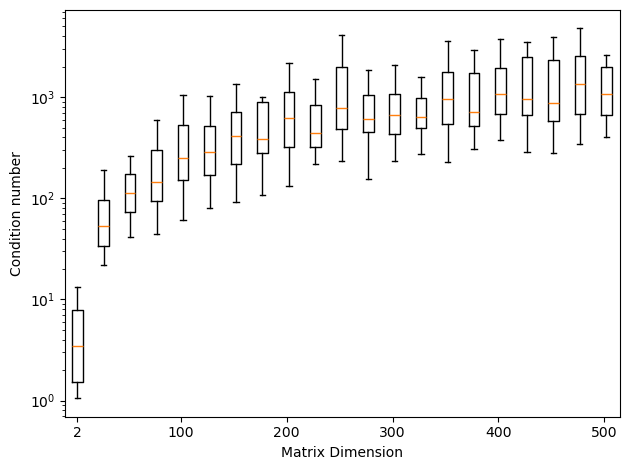

In [156]:
# Plot using boxplots
fig, ax = plt.subplots()

# Create a boxplot for condition numbers grouped by dimension
ax.boxplot(condition_numbers_by_dimension, positions=dimensions, widths=10, showfliers=False)

# Labels and title
ax.set_xlabel('Matrix Dimension')
ax.set_ylabel('Condition number')
ax.set_xticks(ticks=[2,100,200,300,400,500], labels=[2,100,200,300,400,500])

# Logarithmic scale for better visualization
ax.set_yscale('log')
ax.set_xlim(-10,515)

plt.tight_layout()
plt.show()